## Pipeline Description
1. Calibrate images using chessboard images, get camera matrix and distortion coefficients.
2. Undistort each frame in video using computed camera matrix and distortion coefficients.
3. Filter out unnecessary noise in the image, focus on detecting lines:
    1. Apply gradient threshold.
    1. Apply color thresholding on S channel in HLS color space.
4. Define region of interest, apply perspective transform to warp image into bird-eye view.
5. Find the start of the lines using histogram peaks.
6. Fit the polynomial by applying sliding window.
7. Once polynomials exist from X previous frames, search lines from avg of prior polynomials within margin.
8. If lines cannot be detected using search from prior, fallback to histogram peak & sliding window search again.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

## Camera Calibration: Prepare Object and Image Points

In [2]:
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points like (0,0,0),(1,0,0),(2,0,0),...(nx-1,ny-1,0)
nx = 9
ny = 6
patternSize = (nx, ny)
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

total images  20
corners found  17
corners not found  3


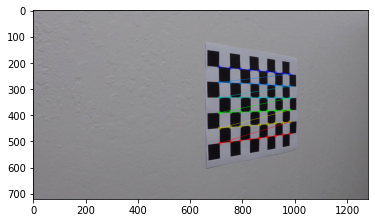

In [3]:
calibFileNames = glob.glob('camera_cal/calibration*.jpg')
cornersNotFoundCount = 0
lastImgWithCorners = None
for fname in calibFileNames:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    patternWasFound, corners = cv2.findChessboardCorners(gray, patternSize, None)
    if patternWasFound == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        img = cv2.drawChessboardCorners(img, patternSize, corners, patternWasFound)
        lastImgWithCorners = img
        # save images locally
        # imgToSave = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        # cv2.imwrite('output_images/' + fname.split('/')[1], imgToSave)
    else:
        cornersNotFoundCount += 1

plt.imshow(lastImgWithCorners)
print("total images ", len(calibFileNames))
print("corners found ", len(objpoints))
print("corners not found ", cornersNotFoundCount)

## Camera Calibration: Calibrate, Undistort

In [4]:
# Calibrate camera -> get camera matrix and distortion coefficients
imgSizeXY = (lastImgWithCorners.shape[1], lastImgWithCorners.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imgSizeXY, None, None)

### Test image undistortion

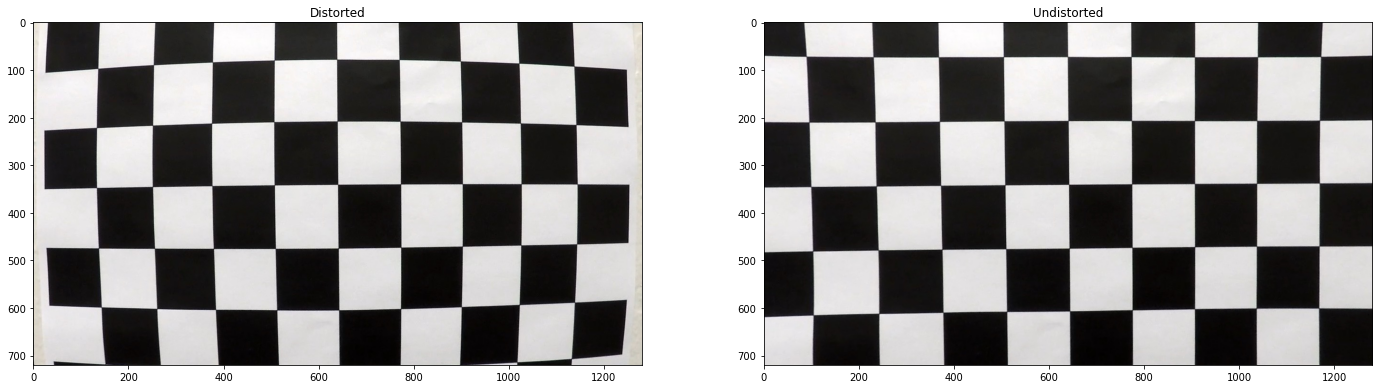

True

In [8]:
distortedImg = mpimg.imread('camera_cal/calibration1.jpg')
undist = cv2.undistort(distortedImg, mtx, dist, None, mtx)

fig=plt.figure(figsize=(24, 9))
columns = 2
rows = 1
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Distorted")
plt.imshow(distortedImg)
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Undistorted")
plt.imshow(undist)
plt.show()

cv2.imwrite('output_images/undistorted_calibration1.jpg', cv2.cvtColor(undist, cv2.COLOR_RGB2BGR))